In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

from fairlearn.metrics import MetricFrame, selection_rate

import sys
sys.path.append(os.path.abspath('..'))
from util import evaluate_model_performance, evaluate_model_fairness, evaluate_train_data_fairness

In [ ]:
data_path = Path(os.getcwd()).parent.parent / "data" / "dataset_diabetes" / "clsf_data"

target_variable = "readmit_30_days"
sensitive_attribute = "race"

X_test = pd.read_csv(data_path / "X_test_split.csv")
X_A_test = pd.read_csv(data_path / "X_A_test_split.csv")
Y_test = pd.read_csv(data_path / "Y_test_split.csv")[target_variable]
A_test = pd.read_csv(data_path / "A_test_split.csv")[sensitive_attribute]

X_train = pd.read_csv(data_path / "X_train_split.csv")
X_A_train = pd.read_csv(data_path / "X_A_train_split.csv")
Y_train = pd.read_csv(data_path / "Y_train_split.csv")[target_variable]
A_train = pd.read_csv(data_path / "A_train_split.csv")[sensitive_attribute]

### Grid search?

In [ ]:
params =  {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': range(10,30)   
}

dtc = DecisionTreeClassifier(random_state=123)

grid_search = GridSearchCV(estimator=dtc,
                    param_grid=params,
                    scoring='recall')

grid_search.fit(X_train, Y_train)

In [ ]:
grid_search.best_score_, grid_search.best_params_

### Decision tree

In [19]:
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=10)

decision_tree.fit(X_train, Y_train)
# Predicting on the test data
decision_tree_pred = decision_tree.predict(X_test)
evaluate_train_data_fairness(X_train, Y_train, A_train)
evaluate_model_performance(Y_test, decision_tree_pred)
evaluate_model_fairness(Y_test, decision_tree_pred, A_test)


===Before training the model===
                selection_rate
race                          
AfricanAmerican       0.111227
Caucasian             0.113056
Other                 0.102564
Unknown               0.083424
The Demographic parity difference score on the training data: 0.029632712453962498
The Disparate impact ratio on the training data: 0.9491723328270318

===After training the model===
The accuracy score for the testing data: 0.8845870387657839
The precision score for the testing data: 0.2328767123287671
The recall score for the testing data: 0.014971378247468076
The F1 score for the testing data: 0.02813405047579644
The F2 score for the testing data: 0.01841820151679307
The specificity score for the testing data: 0.9938059949120672
The balanced accuracy score for the testing data: 0.5043886865797677
The G mean score for the testing data: 0.12197805316707551
[[17970   112]
 [ 2237    34]]
                selection_rate
race                          
AfricanAmerican       0

c:\Users\Tanya\Desktop\TANYA\FMI\Masters\thesis\src\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


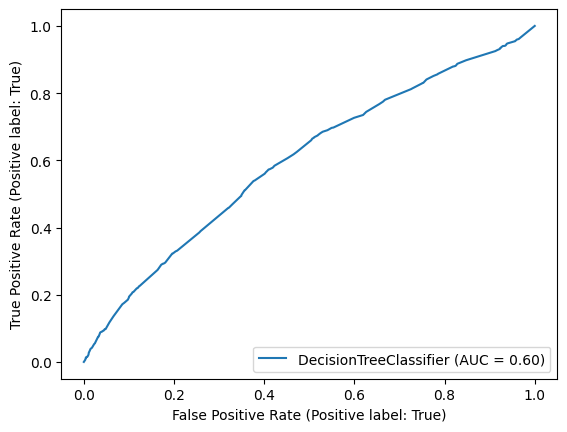

In [20]:
metrics.RocCurveDisplay.from_estimator(decision_tree, X_test, Y_test)

### Inspect feature importance

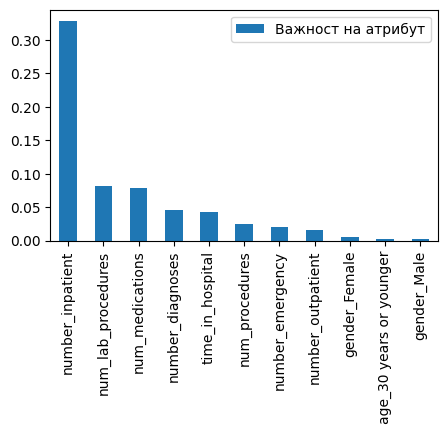

In [21]:
fig, ax = plt.subplots()

feat_importances = pd.DataFrame(decision_tree.feature_importances_[:11], index=X_train.columns[:11], columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(5,3), ax=ax)
#ax = df.plot(kind='bar') # "same" as above
ax.legend(["Важност на атрибут"])

### Further fairness assessment of the baseline model

Disaggregated metrics

In [22]:
metrics_dict = {
    "selection_rate": selection_rate,
    "recall": metrics.recall_score,
    "balanced_accuracy": metrics.balanced_accuracy_score
}

metricframe_baseline = MetricFrame(metrics=metrics_dict,
                  y_true=Y_test,
                  y_pred=decision_tree_pred,
                  sensitive_features=A_test)

metricframe_baseline.by_group

,selection_rate,recall,balanced_accuracy
race,,,
AfricanAmerican,0.007712,0.013304,0.503162
Caucasian,0.007167,0.015222,0.504537
Other,0.006031,0.025641,0.510823
Unknown,0.004706,0.0,0.497442


Statistics about the metrics

In [23]:
pd.DataFrame({'difference': metricframe_baseline.difference(),
              'ratio': metricframe_baseline.ratio(),
              'group_min': metricframe_baseline.group_min(),
              'group_max': metricframe_baseline.group_max()}).T

,selection_rate,recall,balanced_accuracy
difference,0.003006,0.025641,0.013381
ratio,0.610196,0.0,0.973806
group_min,0.004706,0.0,0.497442
group_max,0.007712,0.025641,0.510823


Plot

array([[<Axes: title={'center': 'selection_rate'}, xlabel='race'>,
        <Axes: title={'center': 'recall'}, xlabel='race'>,
        <Axes: title={'center': 'balanced_accuracy'}, xlabel='race'>]],
      dtype=object)

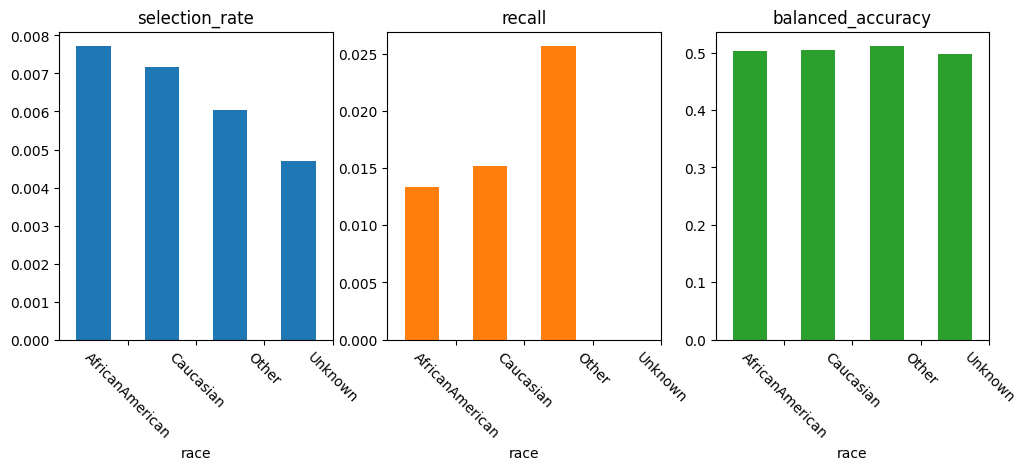

In [24]:
metricframe_baseline.by_group.plot.bar(subplots=True, layout= [1,3], figsize=(12, 4),
                                       legend=False, rot=-45, position=1.5)